In [2]:
import tensorflow as tf
from tensorflow.keras.models import load_model
import tensorflow_probability as tfp
from scipy.interpolate import RectBivariateSpline
import numpy as np
import matplotlib.pyplot as plt
import corner
import importlib
import logging
from tensorflow import keras
import os
from bisect import bisect

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

importlib.reload(logging)

# limit GPU memory
gpus = tf.config.experimental.list_physical_devices('GPU')
try:
    tf.config.experimental.set_visible_devices(gpus[1], 'GPU')
    tf.config.experimental.set_virtual_device_configuration(gpus[1],
    [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=2000)])
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
except RuntimeError as e:
# Visible devices must be set before GPUs have been initialized
    print(e)

2 Physical GPUs, 1 Logical GPU


In [3]:
gaussian_number = 10
latent_dim = 10

In [4]:
model_name = 'test/9'
path = './CVAE/{}/'.format(model_name)
encoder1 = load_model(path + "encoder_1.h5", compile=False)
encoder2 = load_model(path + "encoder_2.h5", compile=False)
decoder = load_model(path + "decoder.h5", compile=False)

In [5]:
data = np.load('../../Data/best_fit_spectrum_DUNE.npz')
data_all = np.column_stack([data['ve_dune_poisson'][:,:36], data['vu_dune_poisson'][:,:36],
                            data['vebar_dune_poisson'][:,:36], data['vubar_dune_poisson'][:,:36]])
true_theta23 = data['theta23_true']
true_delta = data['delta_true']
fit_theta23 = data['theta23_fit']
fit_delta = data['delta_fit']

In [14]:
def sample(n):
    data_poisson_array = data_all[n:n+1]/1000

    mean, log_var, weight = encoder2.predict(data_poisson_array)

    mean = tf.reshape(mean, (-1, gaussian_number, latent_dim))
    log_var = tf.reshape(log_var, (-1, gaussian_number, latent_dim))
    weight = tf.reshape(weight, (-1, gaussian_number))

    SMALL_CONSTANT = 1e-12
    temp_var = SMALL_CONSTANT + tf.exp(log_var)
    test_sampling = tfp.distributions.MixtureSameFamily(
                mixture_distribution=tfp.distributions.Categorical(logits=weight),
                components_distribution=tfp.distributions.MultivariateNormalDiag(
                loc=mean,
                scale_diag=tf.sqrt(temp_var)))

    sample_amount= 10000
    sample_times = 10
    mean = []
    prediction = []
    for i in range(sample_times):
        Z3 = np.reshape(test_sampling.sample(sample_shape=(sample_amount)), (sample_amount, latent_dim))
        reconstruction_mean, reconstruction_var = decoder.predict([Z3, np.array(([data_poisson_array[0]]*sample_amount))])
        mean.extend(reconstruction_mean)
        temp_var = SMALL_CONSTANT + tf.exp(reconstruction_var)
        reconstruction_parameter = tfp.distributions.MultivariateNormalDiag(
                                loc=reconstruction_mean,
                                scale_diag=temp_var)
        prediction.extend(reconstruction_parameter.sample().numpy())

    mean = np.array(mean)*180/np.pi
    prediction = np.array(prediction)*180/np.pi
    return mean, prediction


In [30]:
def in_contour(target, n , title):
    bins_theta23 = np.linspace(min(target[:, 1]), max(target[:, 1]), 100)
    bins_delta = np.linspace(min(target[:, 2]), max(target[:, 2]), 100)

    likeliregion, xedges, yedges = np.histogram2d(target[:,1], target[:,2], bins = [bins_theta23,bins_delta])
    likeliregion = likeliregion.T

    max_poi = np.where(likeliregion == likeliregion.max())

    
    sorted_list = np.sort(likeliregion.reshape((len(xedges)-1)*(len(yedges)-1)))[::-1]
    tot_event_num = sorted_list.sum()

    count = 0
    one_sigma_num, two_sigma_num = 0, 0
    for i in range(len(sorted_list)):
        count += sorted_list[i]/tot_event_num
        if count >= 0.68 and one_sigma_num == 0:
            one_sigma_num = sorted_list[i]
        if count >= 0.95:
            two_sigma_num = sorted_list[i]
            break

    one_sigma_region = np.where(likeliregion < one_sigma_num, 0, likeliregion)
    one_sigma_region_boundary = np.where(one_sigma_region > 0, 1, one_sigma_region)

    two_sigma_region = np.where(likeliregion < two_sigma_num, 0, likeliregion)
    two_sigma_region_boundary = np.where(two_sigma_region > 0, 1, two_sigma_region)
    xaxis, yaxis = (xedges[:-1] + xedges[1:])/2, (yedges[:-1] + yedges[1:])/2

    plt.figure(figsize=(8,8))
    plt.contour(xaxis, yaxis, one_sigma_region_boundary, 0, colors='green', linestyles="-", linewidths=1)
    plt.contour(xaxis, yaxis, two_sigma_region_boundary, 0, colors='red', linestyles="-", linewidths=1)
    plt.scatter(xedges[max_poi[1]],yedges[max_poi[0]], label='Maximum: theta23 {}, delta {}'.format(round(xedges[max_poi[1]][0], 2),round(yedges[max_poi[0]][0], 2)))
    plt.scatter(true_theta23[n]*180/np.pi, true_delta[n], label='true: theta23 {}, delta {}'.format(round(true_theta23[n]*180/np.pi, 2), round(true_delta[n], 2)))
    plt.scatter(fit_theta23[n]*180/np.pi, fit_delta[n], label='best fit: theta23 {}, delta {}'.format(round(fit_theta23[n]*180/np.pi, 2), round(fit_delta[n], 2)))
    plt.legend()
    plt.xlim(0, 90)
    plt.ylim(0, 360)
    plt.title(title + ' ' + str(n))
    plt.show()

    a = one_sigma_region[bisect(bins_theta23, true_theta23[n]*180/np.pi)-1][bisect(bins_delta, true_delta[n])-1] != 0.0
    b = two_sigma_region[bisect(bins_theta23, true_theta23[n]*180/np.pi)-1][bisect(bins_delta, true_delta[n])-1] != 0.0
    c = one_sigma_region[bisect(bins_theta23, fit_theta23[n]*180/np.pi)-1][bisect(bins_delta, fit_delta[n])-1] != 0.0
    d = two_sigma_region[bisect(bins_theta23, fit_theta23[n]*180/np.pi)-1][bisect(bins_delta, fit_delta[n])-1] != 0.0
    return np.array([a, b, c, d])


/tmp/ipykernel_2492751/2372122569.py:32: UserWarning: No contour levels were found within the data range.
  plt.contour(xaxis, yaxis, one_sigma_region_boundary, 0, colors='green', linestyles="-", linewidths=1)
/tmp/ipykernel_2492751/2372122569.py:33: UserWarning: No contour levels were found within the data range.
  plt.contour(xaxis, yaxis, two_sigma_region_boundary, 0, colors='red', linestyles="-", linewidths=1)


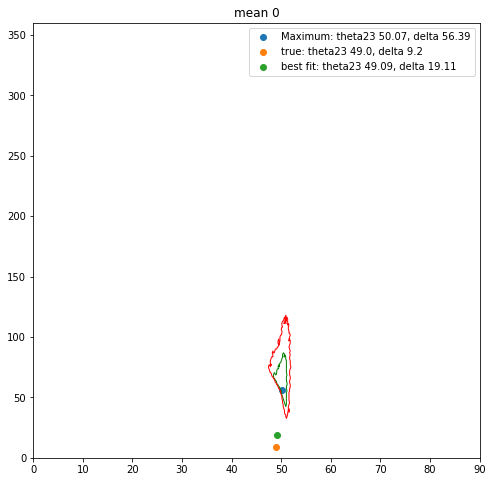

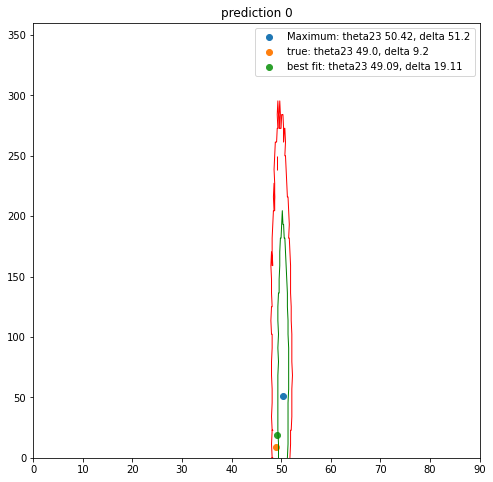

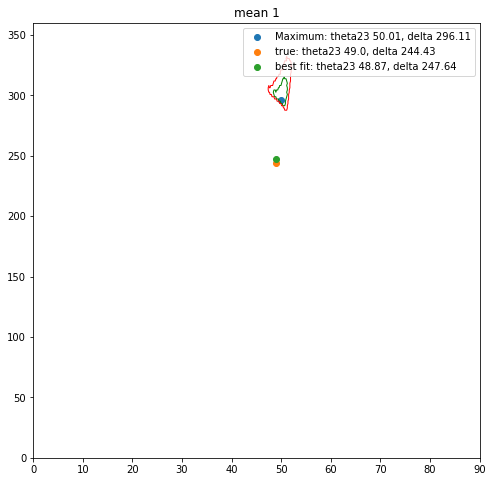

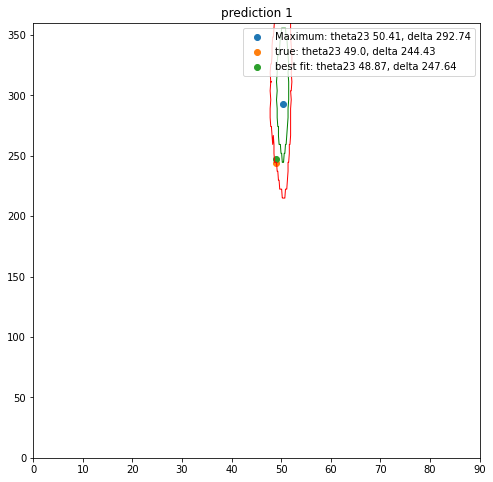

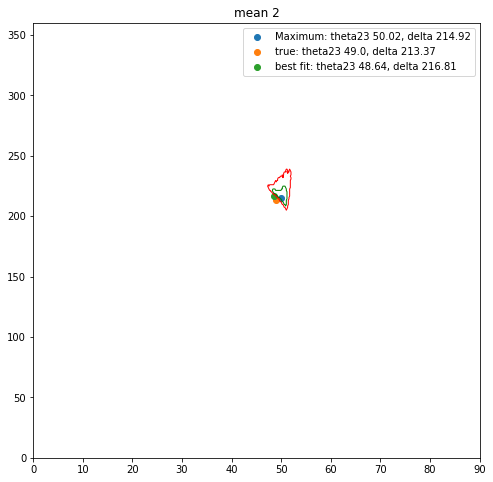

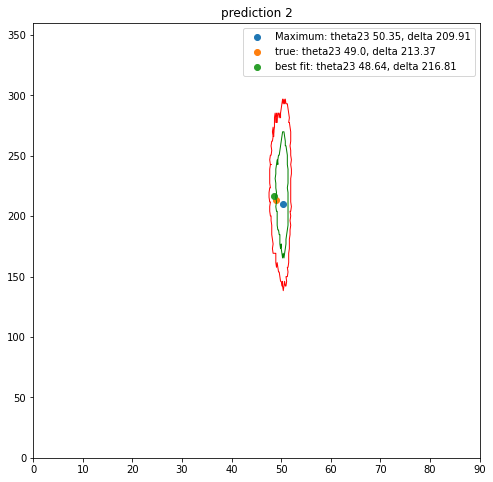

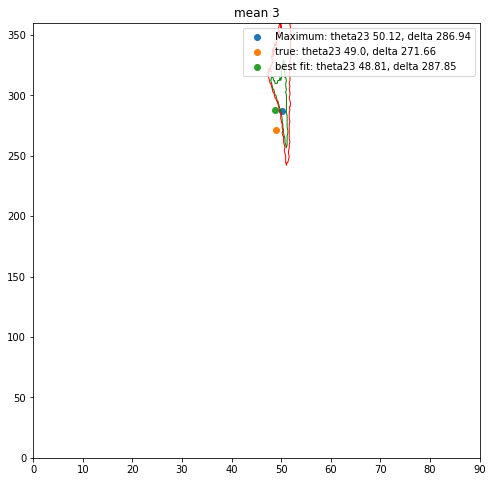

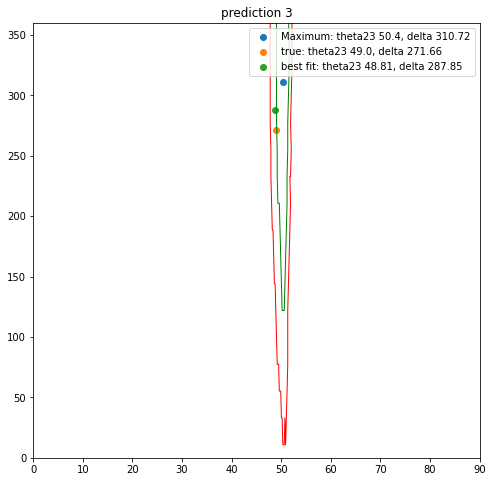

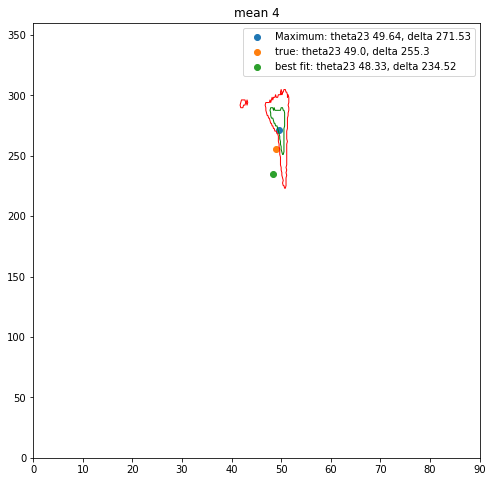

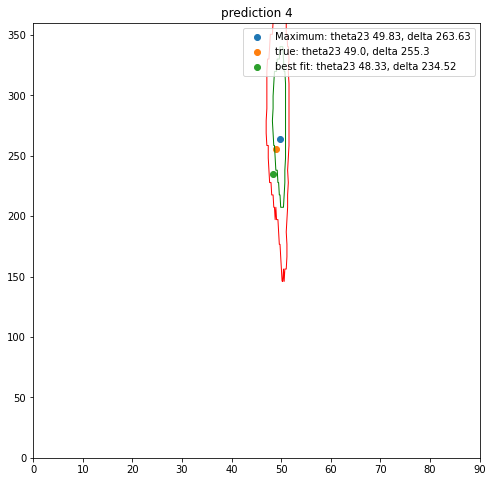

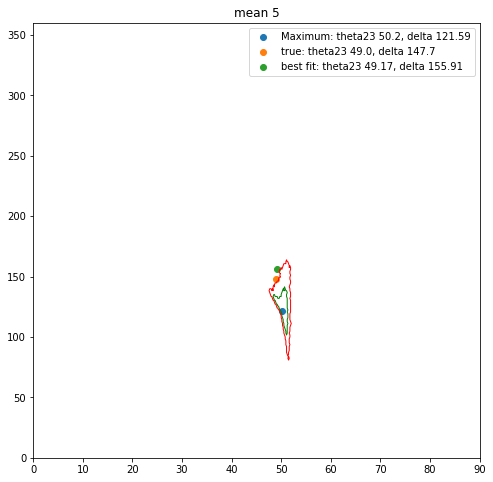

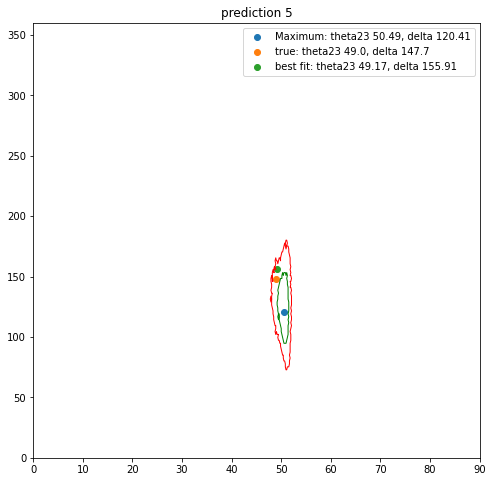

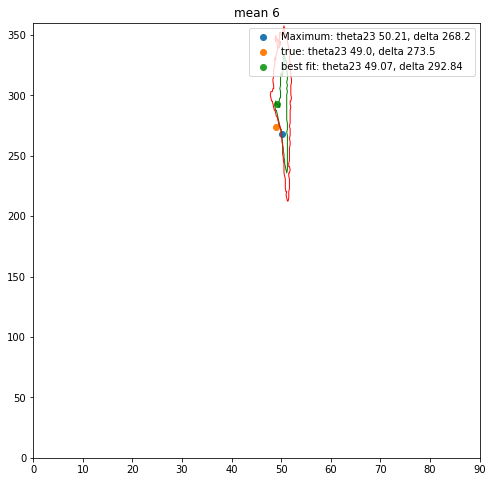

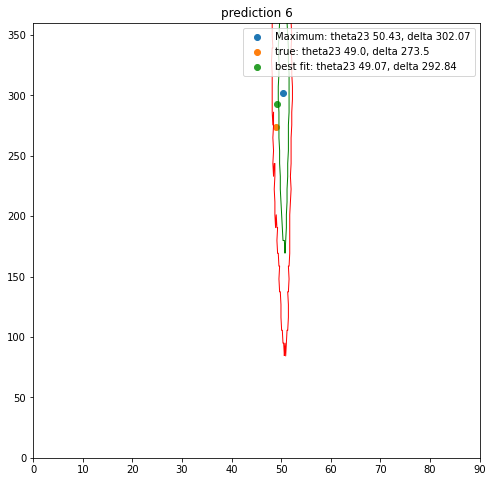

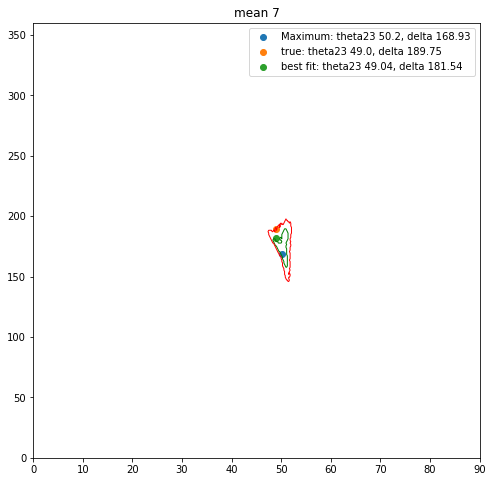

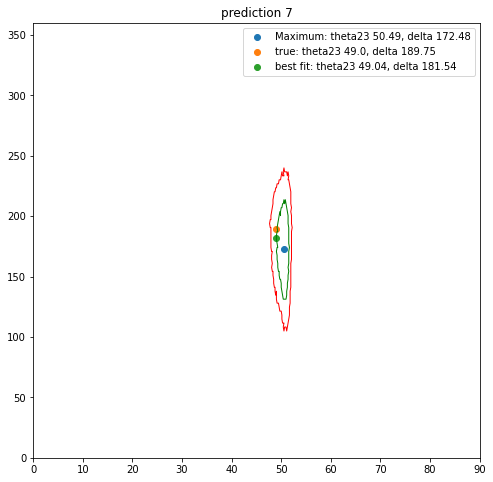

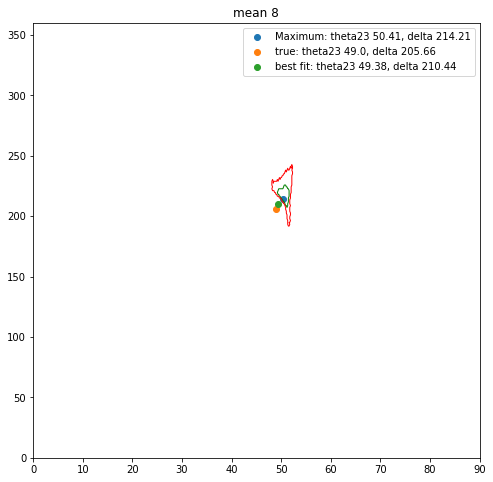

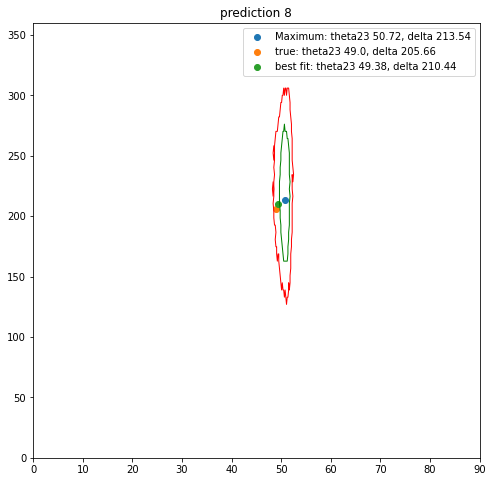

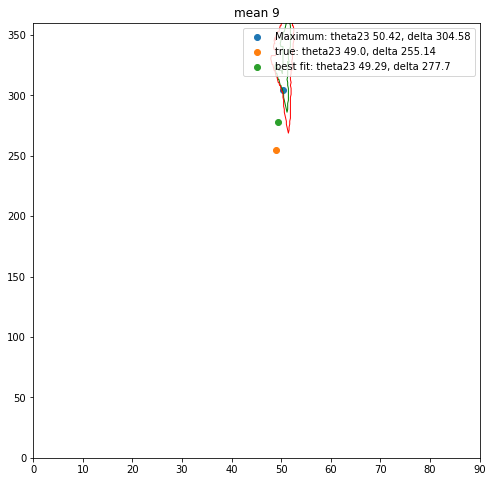

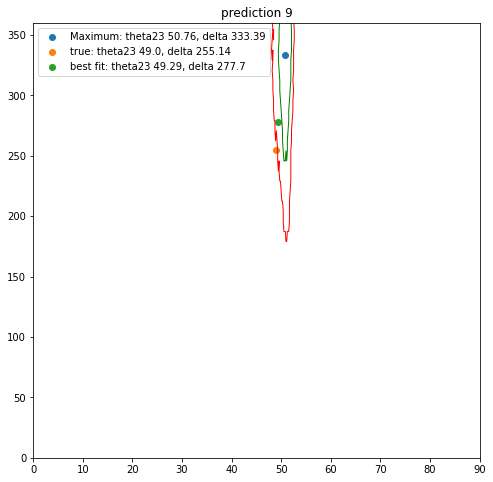

In [31]:
#true_one_sigma, true_two_sigma, fit_one_sigma, fit_two_sigma
in_mean = np.array([0, 0, 0, 0])
in_pred = np.array([0, 0, 0, 0])

for i in range(10):
    mean, prediction = sample(i)
    in_mean += in_contour(mean, i, 'mean')
    in_pred += in_contour(prediction, i, 'prediction')

In [32]:
print(in_mean, in_pred)

[2 2 2 2] [0 3 0 4]
